# Exploring Deep Deterministic Policy Gradient (DDPG): A Case Study in the Continous Mountain Car Environment


**Goal**: Perform Hyperparameter tuning on the DDPG algorithm to investiage the behaviour of the agent in the environment.

## Configuration for Colab

In [ ]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install pyvirtualdisplay
    from pyvirtualdisplay import Display

    # Start virtual display
    dis = Display(visible=0, size=(600, 400))
    dis.start()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 38 not upgraded.
Need to get 7,814 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main

## Import modules

In [ ]:
import copy
import random
from typing import Dict, List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning
)

from IPython.display import clear_output

## Set random seed

In [ ]:
if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed = 777
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Replay Buffer

In [ ]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        """Initializate."""
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros([size], dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray,
        rew: float,
        next_obs: np.ndarray,
        done: bool,
    ):
        """Store the transition in buffer."""
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        """Randomly sample a batch of experiences from memory."""
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

## OU Noise


In [ ]:
class OUNoise:
    """Ornstein-Uhlenbeck process.
    Taken from Udacity deep-reinforcement-learning github repository:
    https://github.com/udacity/deep-reinforcement-learning/blob/master/
    ddpg-pendulum/ddpg_agent.py
    """

    def __init__(
        self,
        size: int,
        mu: float = 0.0,
        theta: float = 0.15,
        sigma: float = 0.2,
    ):
        """Initialize parameters and noise process."""
        self.state = np.float64(0.0)
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self) -> np.ndarray:
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array(
            [random.random() for _ in range(len(x))]
        )
        self.state = x + dx
        return self.state

## Network


In [ ]:
class Actor(nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(Actor, self).__init__()

        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, out_dim)

        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))
        action = self.out(x).tanh()

        return action


class Critic(nn.Module):
    def __init__(
        self,
        in_dim: int,
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(Critic, self).__init__()

        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1)

        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(
        self, state: torch.Tensor, action: torch.Tensor
    ) -> torch.Tensor:
        """Forward method implementation."""
        x = torch.cat((state, action), dim=-1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        value = self.out(x)

        return value

## DDPG Agent
Here is a summary of DDPGAgent class.

| Method           | Note                                                 |
|---               |---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|\_target_soft_update| soft update from the local model to the target model.|
|\_plot              | plot the training progresses.                        |

In [ ]:
class DDPGAgent:
    """DDPGAgent interacting with environment.

    Attribute:
        env (gym.Env): openAI Gym environment
        actor (nn.Module): target actor model to select actions
        actor_target (nn.Module): actor model to predict next actions
        actor_optimizer (Optimizer): optimizer for training actor
        critic (nn.Module): critic model to predict state values
        critic_target (nn.Module): target critic model to predict state values
        critic_optimizer (Optimizer): optimizer for training critic
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        gamma (float): discount factor
        tau (float): parameter for soft target update
        initial_random_steps (int): initial random action steps
        noise (OUNoise): noise generator for exploration
        device (torch.device): cpu / gpu
        transition (list): temporory storage for the recent transition
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
    """
    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        ou_noise_theta: float,
        ou_noise_sigma: float,
        gamma: float ,
        tau: float = 5e-3,
        # actor_path: str='actor_model.h5',
        # critic_path: str='critic_model.h5',
        initial_random_steps: int = 1e4,
    ):
        """Initialize."""
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]

        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        # self.actor_path: actor_path,
        # self.critic_path: critic_path,
        self.initial_random_steps = initial_random_steps

        # noise
        self.noise = OUNoise(
            action_dim,
            theta=ou_noise_theta,
            sigma=ou_noise_sigma,
        )

        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        # print(self.device)

        # networks
        self.actor = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())

        self.critic = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())

        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        # transition to store in memory
        self.transition = list()

        # total steps count
        self.total_step = 0

        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # if initial random action should be conducted
        if self.total_step < self.initial_random_steps and not self.is_test:
            selected_action = self.env.action_space.sample()
        else:
            selected_action = self.actor(
                torch.FloatTensor(state).to(self.device)
            ).detach().cpu().numpy()

        # add noise for exploration during training
        if not self.is_test:
            noise = self.noise.sample()
            selected_action = np.clip(selected_action + noise, -1.0, 1.0)

        self.transition = [state, selected_action]
        # print("the selected action is :", selected_action)
        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, _ = self.env.step(action)

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)
        # print("the next steps:", next_state, reward, done)
        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        device = self.device  # for shortening the following lines

        samples = self.memory.sample_batch()
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.FloatTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        masks = 1 - done
        next_action = self.actor_target(next_state)
        next_value = self.critic_target(next_state, next_action)
        curr_return = reward + self.gamma * next_value * masks

        # train critic
        values = self.critic(state, action)
        critic_loss = F.mse_loss(values, curr_return)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # train actor
        actor_loss = -self.critic(state, self.actor(state)).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # target update
        self._target_soft_update()

        return actor_loss.data, critic_loss.data

    def save_models(self, actor_path: str, critic_path: str):
        """Save actor and critic models to specified paths."""
        torch.save(self.actor.state_dict(), actor_path)
        torch.save(self.critic.state_dict(), critic_path)

    def train(self, num_frames: int, actor_path: str = 'actor_model.pth', critic_path: str = 'critic_model.pth', plotting_interval: int = 50000):
        """Train the agent."""
        self.is_test = False

        state = self.env.reset()
        actor_losses = []
        critic_losses = []
        scores = []
        score = 0

        for self.total_step in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # if episode ends
            if done:
                state = env.reset()
                scores.append(score)
                score = 0

            # if training is ready
            if (
                len(self.memory) >= self.batch_size
                and self.total_step > self.initial_random_steps
            ):
                actor_loss, critic_loss = self.update_model()
                actor_losses.append(actor_loss)
                critic_losses.append(critic_loss)

            # plotting
            # if self.total_step % plotting_interval == 0:
        self._plot(
                # self.total_step,
                scores,
                actor_losses,
                critic_losses,
            )


          # saving models
        self.save_models(actor_path, critic_path)

        self.env.close()

    def test(self):
        """Test the agent."""
        self.is_test = True

        state = self.env.reset()
        done = False
        score = 0

        frames = []
        while not done:
            frames.append(self.env.render(mode="rgb_array"))
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

        print("Total Rewards: ", score)
        self.env.close()

        return frames, score

    def save_models(self, actor_path: str, critic_path: str):
        """Save actor and critic models to specified paths."""
        torch.save(self.actor.state_dict(), actor_path)
        torch.save(self.critic.state_dict(), critic_path)

    def _target_soft_update(self):
        """Soft-update: target = tau*local + (1-tau)*target."""
        tau = self.tau

        for t_param, l_param in zip(
            self.actor_target.parameters(), self.actor.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)

        for t_param, l_param in zip(
            self.critic_target.parameters(), self.critic.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)

    def _plot(
        self,
        # frame_idx: int,
        scores: List[float],
        actor_losses: List[float],
        critic_losses: List[float],
    ):
        """Plot the training progresses."""
        plt.figure(figsize=(15, 5))

        # Plot scores
        plt.subplot(131)
        plt.title(f"Total Rewards")
        plt.plot(scores)
        plt.xlabel("Episode")
        plt.ylabel("Rewards")

        # Plot actor losses
        plt.subplot(132)
        plt.title("Actor Loss")
        plt.plot(actor_losses)
        plt.xlabel("Step")
        plt.ylabel("Loss")

        # Plot critic losses
        plt.subplot(133)
        plt.title("Critic Loss")
        plt.plot(critic_losses)
        plt.xlabel("Step")
        plt.ylabel("Loss")

        plt.tight_layout()
        plt.show()

## Environment


In [ ]:
class ActionNormalizer(gym.ActionWrapper):
    """Rescale and relocate the actions."""

    def action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (-1, 1) to (low, high)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = action * scale_factor + reloc_factor
        action = np.clip(action, low, high)

        return action

    def reverse_action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (low, high) to (-1, 1)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = (action - reloc_factor) / scale_factor
        action = np.clip(action, -1.0, 1.0)

        return action

In [ ]:
# environment
env_id = "MountainCarContinuous-v0"
env = gym.make(env_id)
env = ActionNormalizer(env)

## Set random seed

## Initialize

In [ ]:
def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

seed = 777
random.seed(seed)
np.random.seed(seed)
seed_torch(seed)
env.seed(seed)

[777]

In [ ]:
# parameters
num_frames = 50000
memory_size = 100000
batch_size = 64
ou_noise_theta = 1.0
ou_noise_sigma = 0.1
my_gamma=0.9
initial_random_steps = 10000

agent = DDPGAgent(
    env,
    memory_size,
    batch_size,
    ou_noise_theta,
    ou_noise_sigma,
    gamma=my_gamma,
    initial_random_steps=initial_random_steps
)

## Train

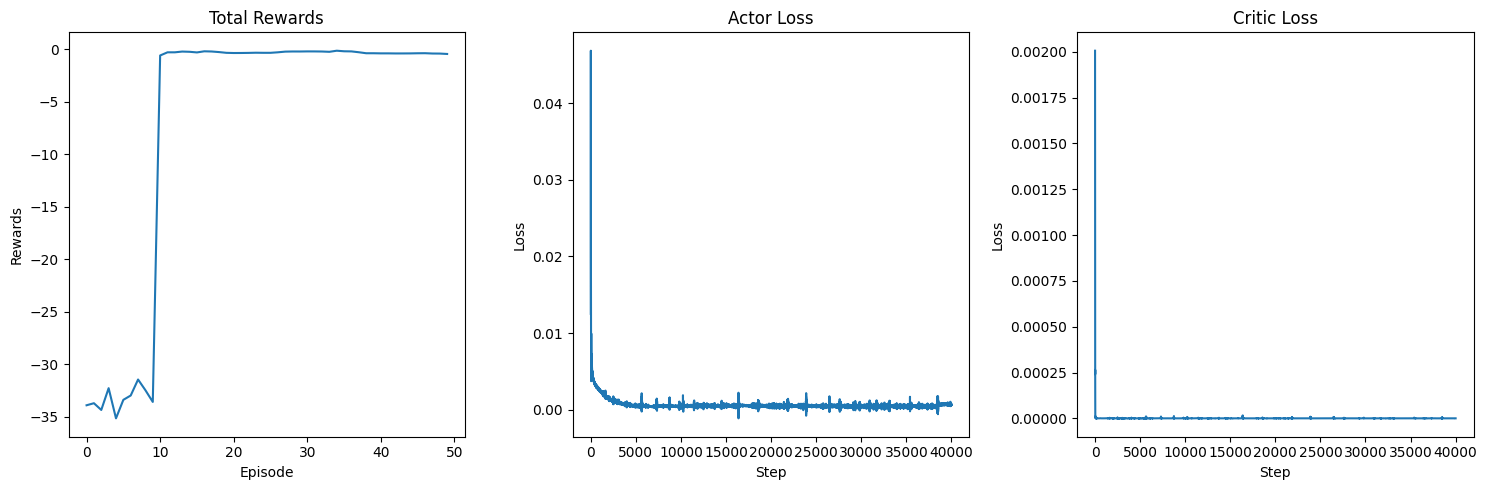

In [ ]:
agent.train(num_frames)

## Test
Run the trained agent (1 episode).

In [ ]:
from gym.wrappers.record_video import RecordVideo

if IN_COLAB:
    agent.env = RecordVideo(agent.env, "videos")
new_frames = agent.test()[0]


Total Rewards:  -0.0070895518109470096


## Render

In [ ]:
pip install JSAnimation

  Preparing metadata (setup.py) ... done
  Created wheel for JSAnimation: filename=JSAnimation-0.1-py3-none-any.whl size=11404 sha256=adb15b53f3d950b1789112b4e6d4c21241c82dc500cdad3b336b21ab86affe27
  Stored in directory: /root/.cache/pip/wheels/1e/16/64/028f540fe8f5eae5026a423bfd88356248074379b79f27b646
Successfully built JSAnimation


In [ ]:
def display_agent_video(frames):

  if IN_COLAB:  # for colab
      import base64
      import glob
      import io
      import os

      from IPython.display import HTML, display

      def ipython_show_video(path: str) -> None:
          """Show a video at `path` within IPython Notebook."""
          if not os.path.isfile(path):
              raise NameError("Cannot access: {}".format(path))

          video = io.open(path, "r+b").read()
          encoded = base64.b64encode(video)

          display(HTML(
              data="""
              <video alt="test" controls>
              <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
              </video>
              """.format(encoded.decode("ascii"))
          ))

      list_of_files = glob.glob("videos/*.mp4")
      latest_file = max(list_of_files, key=os.path.getctime)
      # print(latest_file)
      ipython_show_video(latest_file)

  else:  # for jupyter
      from matplotlib import animation
      from JSAnimation.IPython_display import display_animation
      from IPython.display import display


      def display_frames_as_gif(frames):
          """Displays a list of frames as a gif, with controls."""
          patch = plt.imshow(frames[0])
          plt.axis('off')

          def animate(i):
              patch.set_data(frames[i])

          anim = animation.FuncAnimation(
              plt.gcf(), animate, frames = len(frames), interval=50
          )
          display(display_animation(anim, default_mode='loop'))


      # display
      display_frames_as_gif(frames)


display_agent_video(new_frames)

# Hyper Parameter tuning

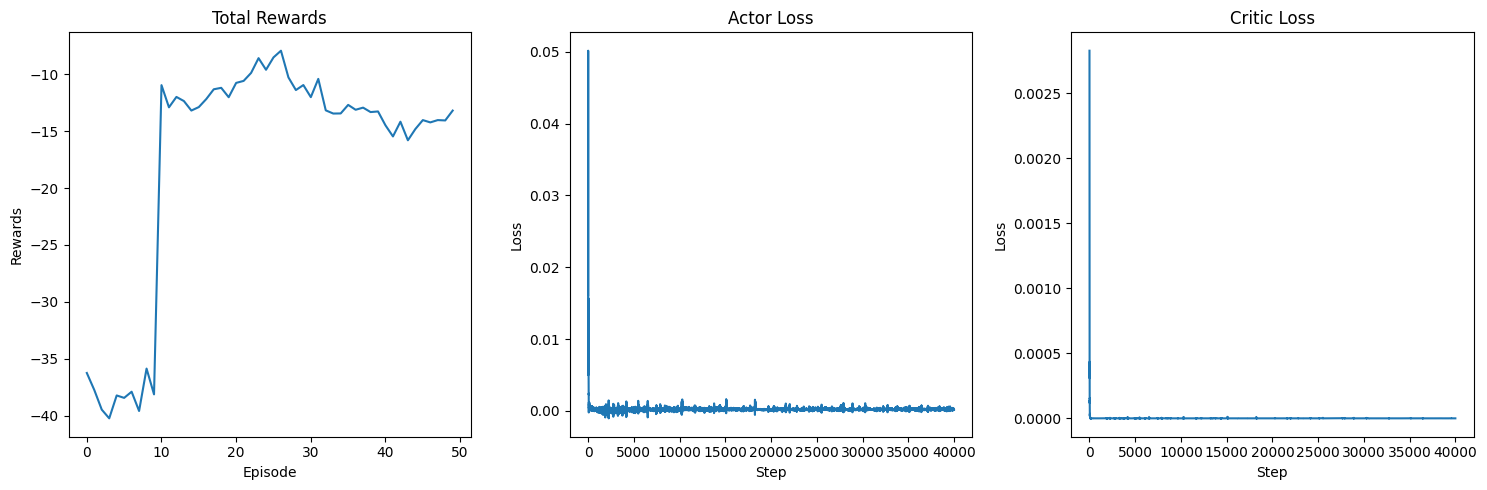

Total Rewards:  -0.180520060835928
Total Rewards:  -0.18059435472587726


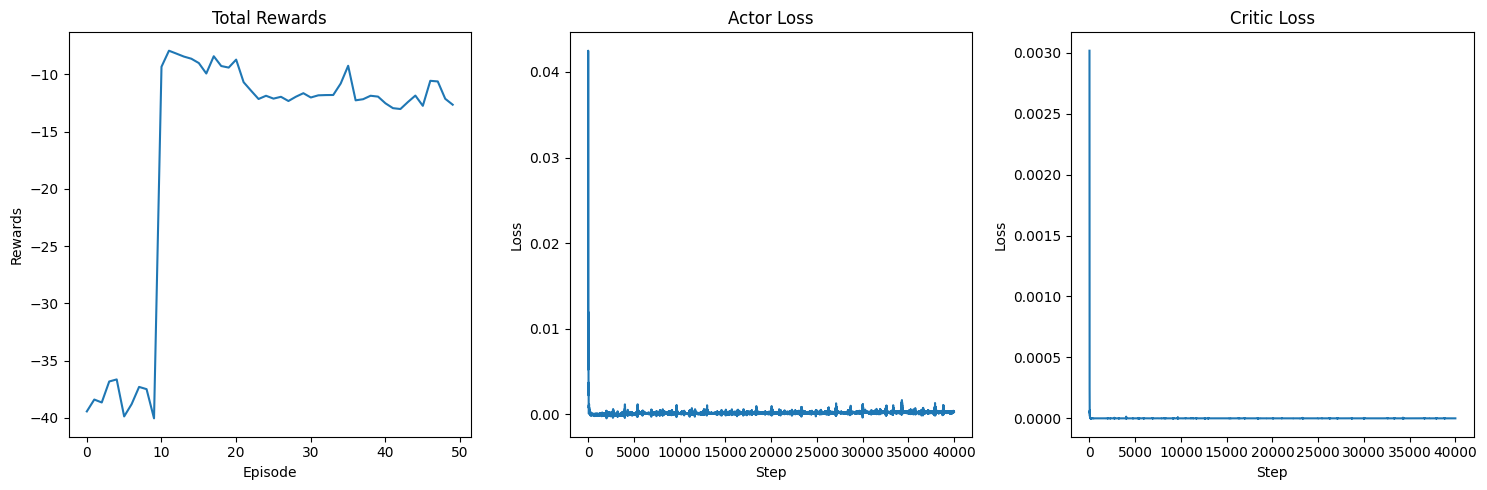

Total Rewards:  -0.007504166164372447
Total Rewards:  -0.008807861986388424


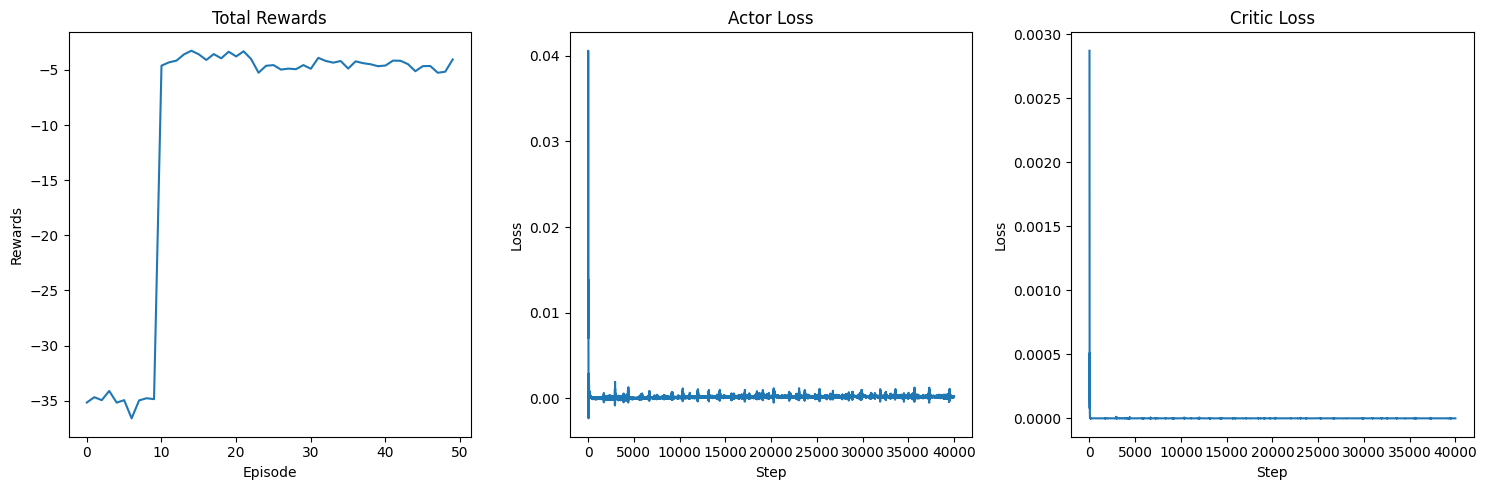

Total Rewards:  -0.022674174875603616
Total Rewards:  -0.022830826181492965


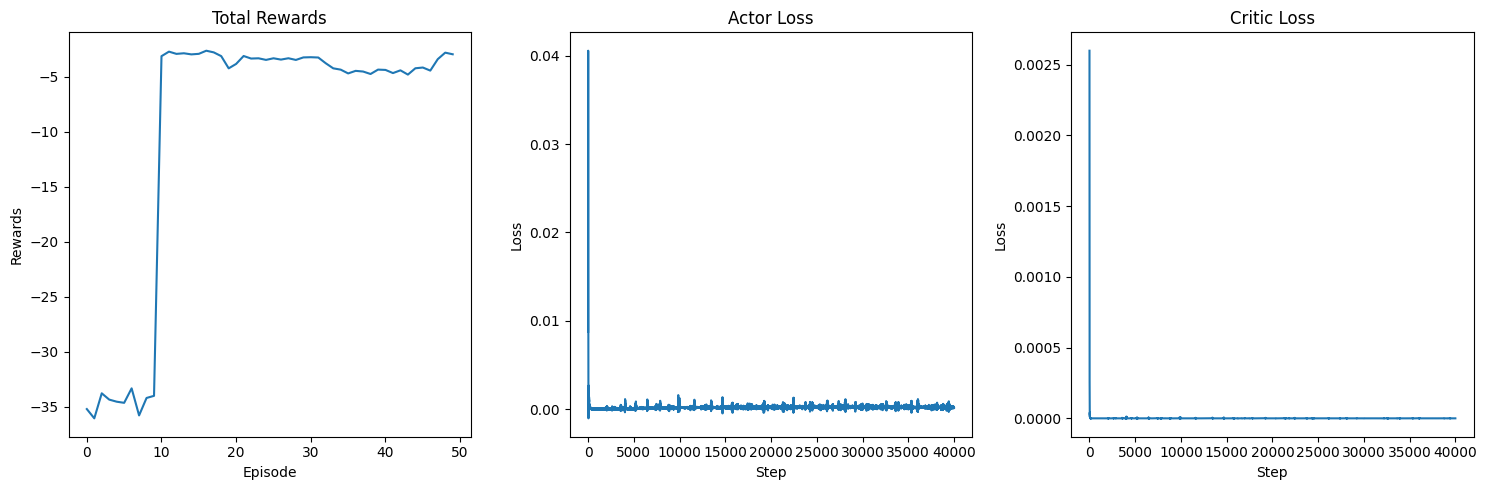

Total Rewards:  -0.13288106551133352
Total Rewards:  -0.130102591115261


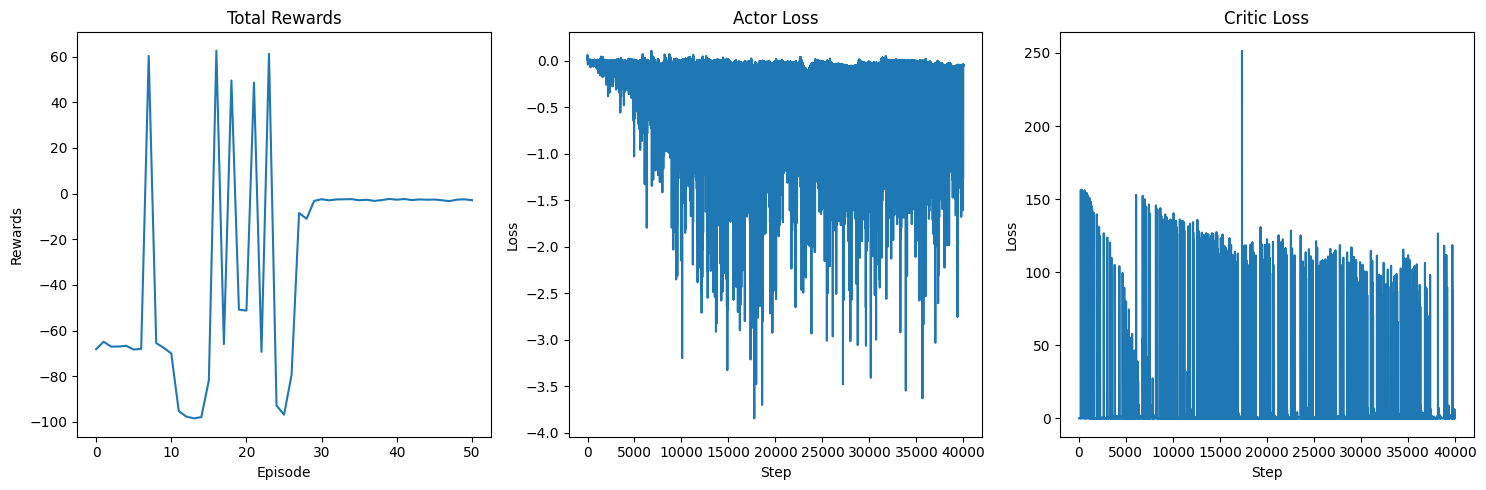

Total Rewards:  -99.8999999999986
Total Rewards:  -99.8999999999986


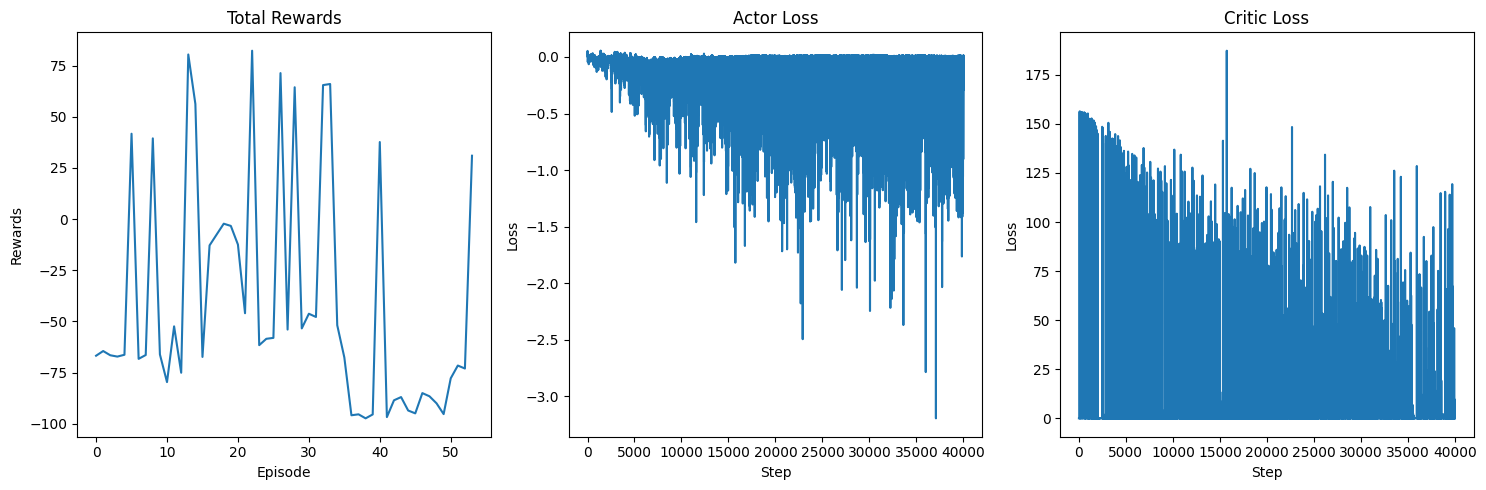

Total Rewards:  -16.80245661984347
Total Rewards:  -15.902759595946025


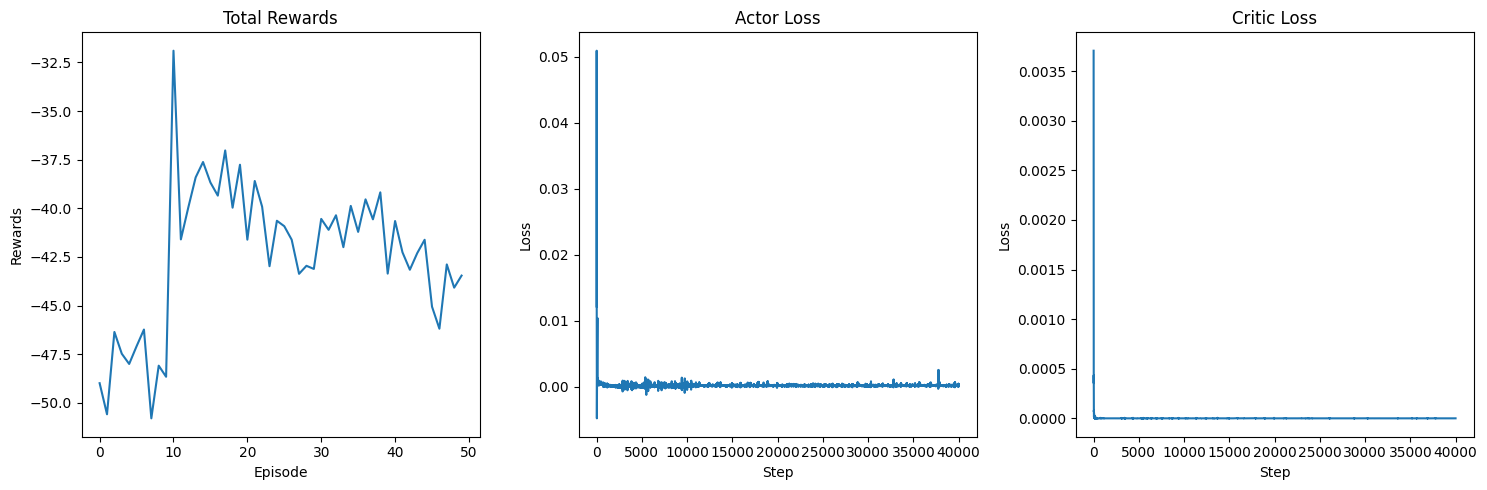

Total Rewards:  -0.2023508670003045
Total Rewards:  -0.2019470897074193


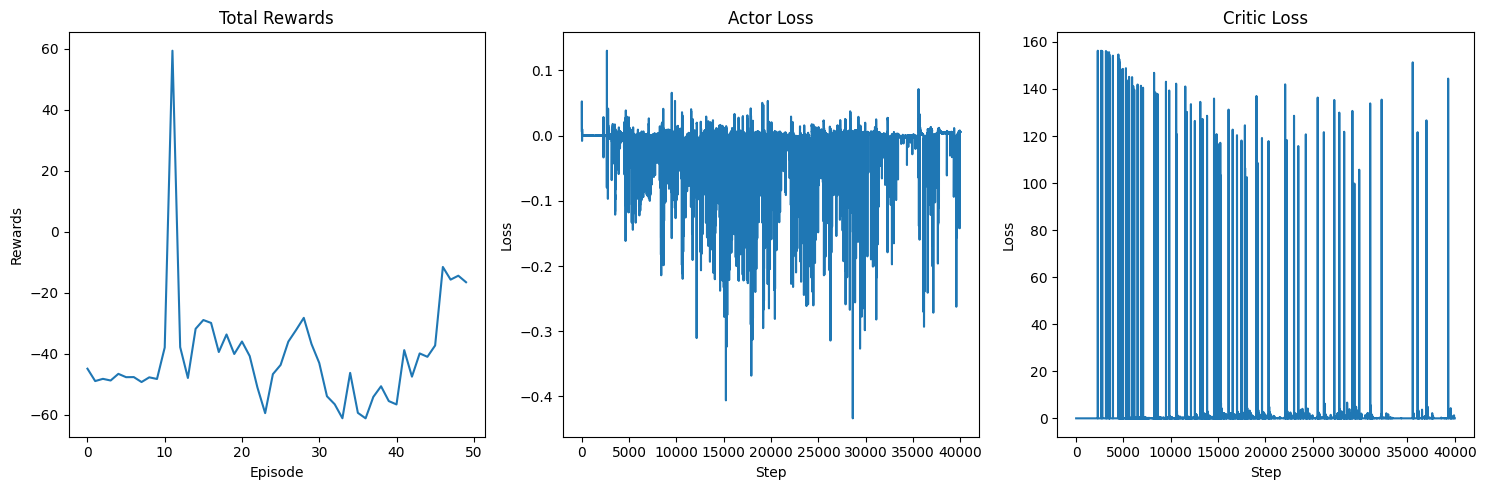

Total Rewards:  -1.3222349176082902
Total Rewards:  -1.283911045889901


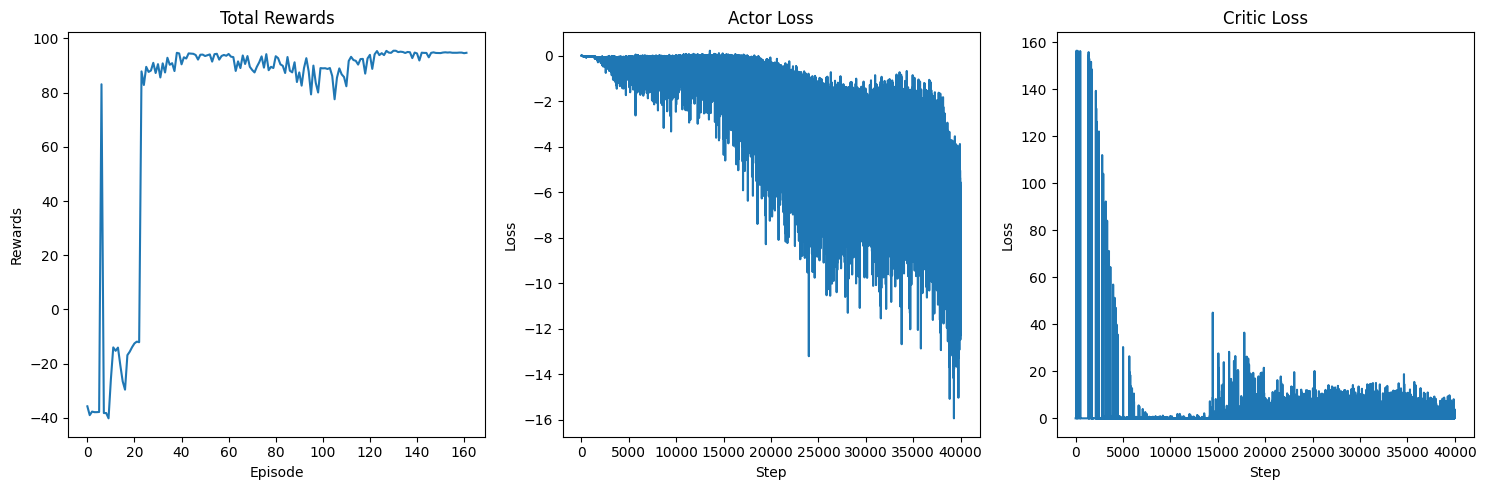

Total Rewards:  93.65837965664291
Total Rewards:  93.63568653966705


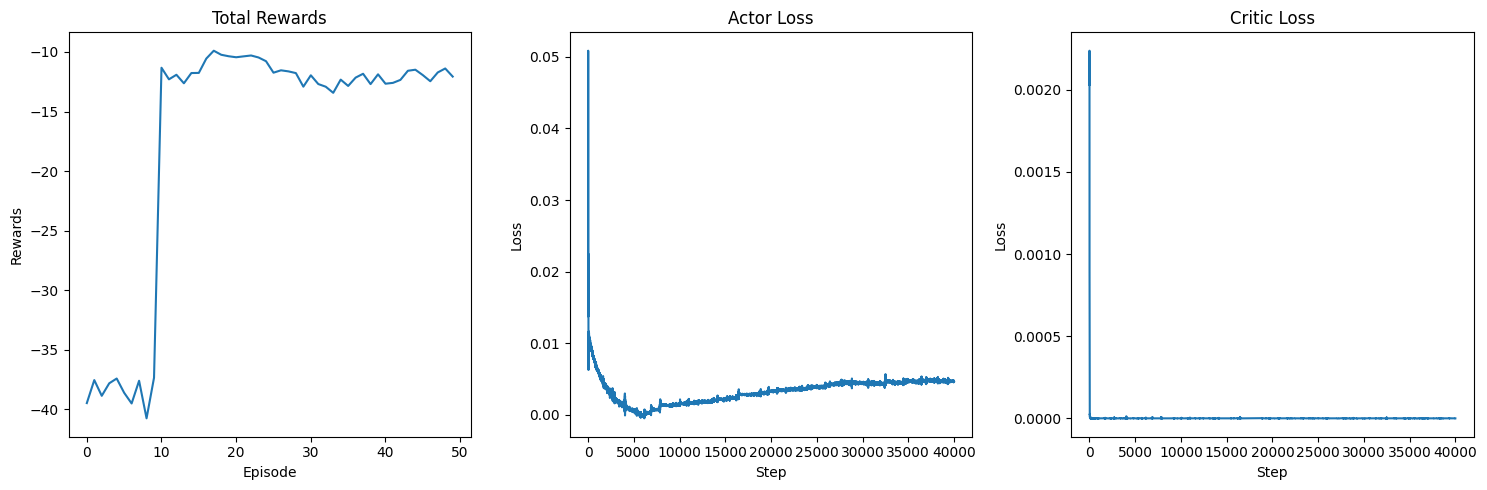

Total Rewards:  -0.0024531143085936074
Total Rewards:  -0.0025839985508565684


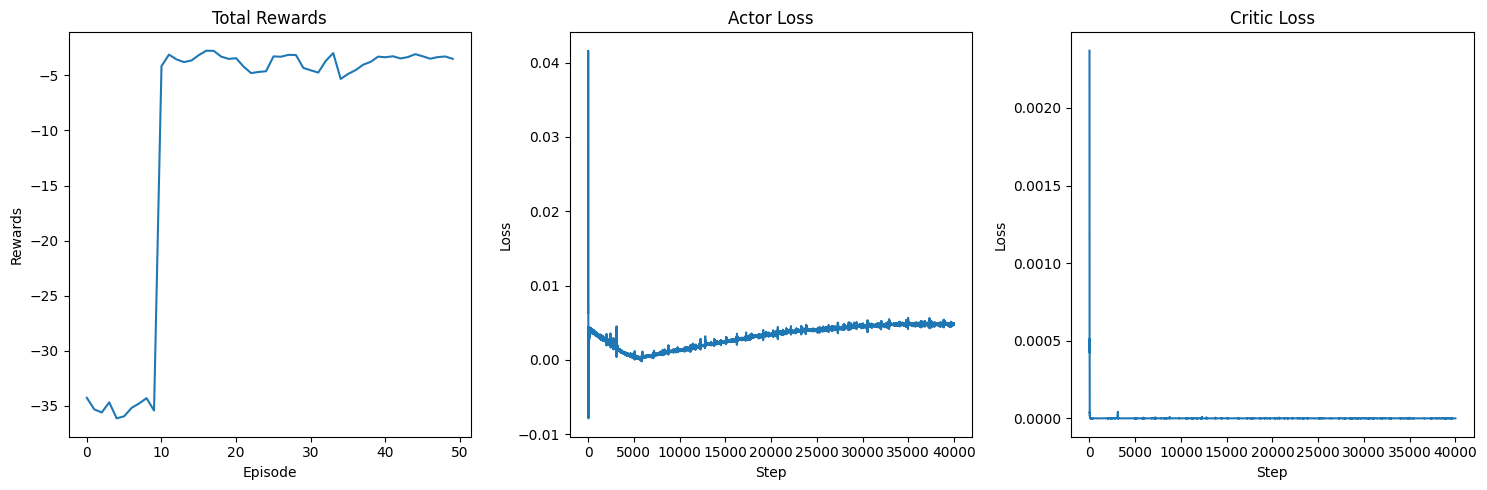

Total Rewards:  -0.03299406984519637
Total Rewards:  -0.03335688080943751


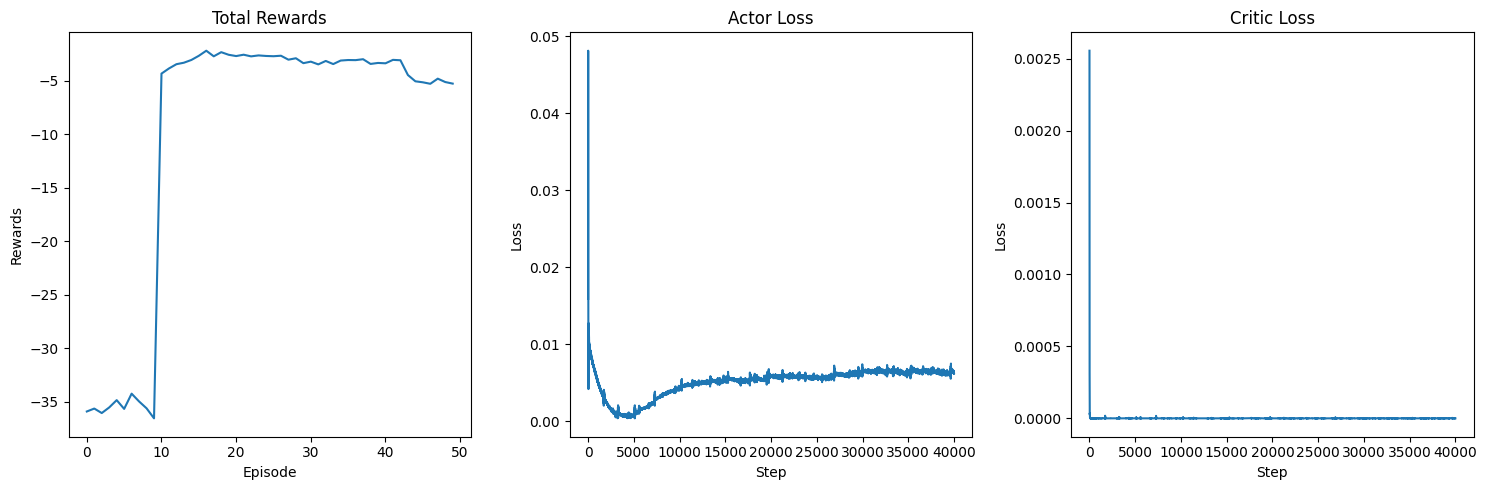

Total Rewards:  -0.04392308587704332
Total Rewards:  -0.04355113480919966


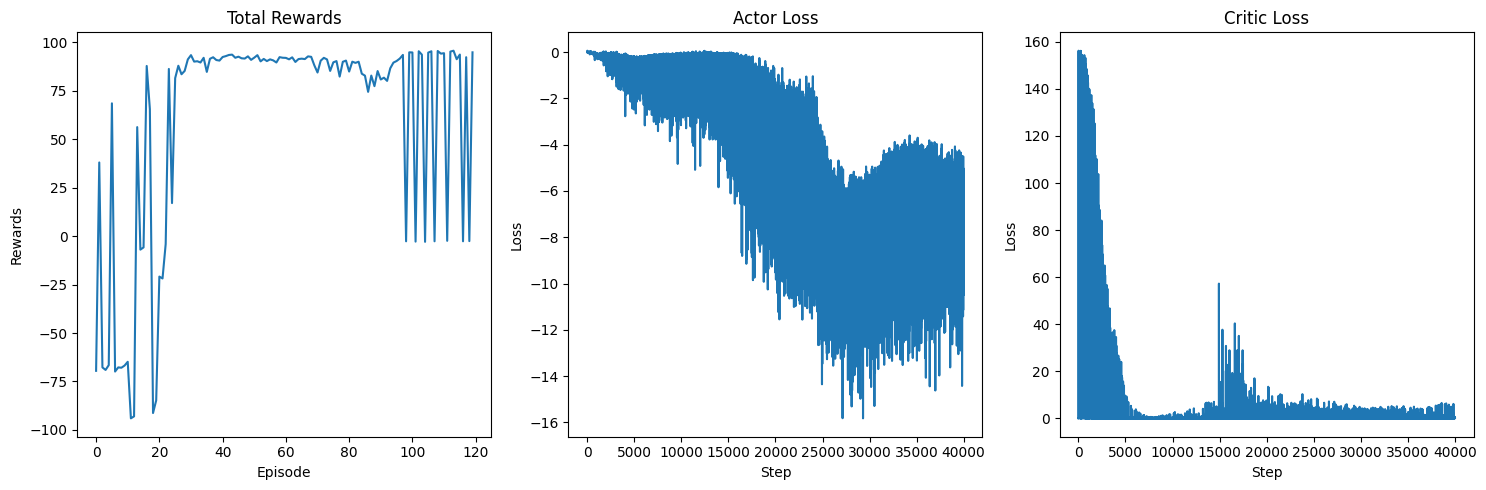

Total Rewards:  -99.89989233021139
Total Rewards:  -99.8998457909538


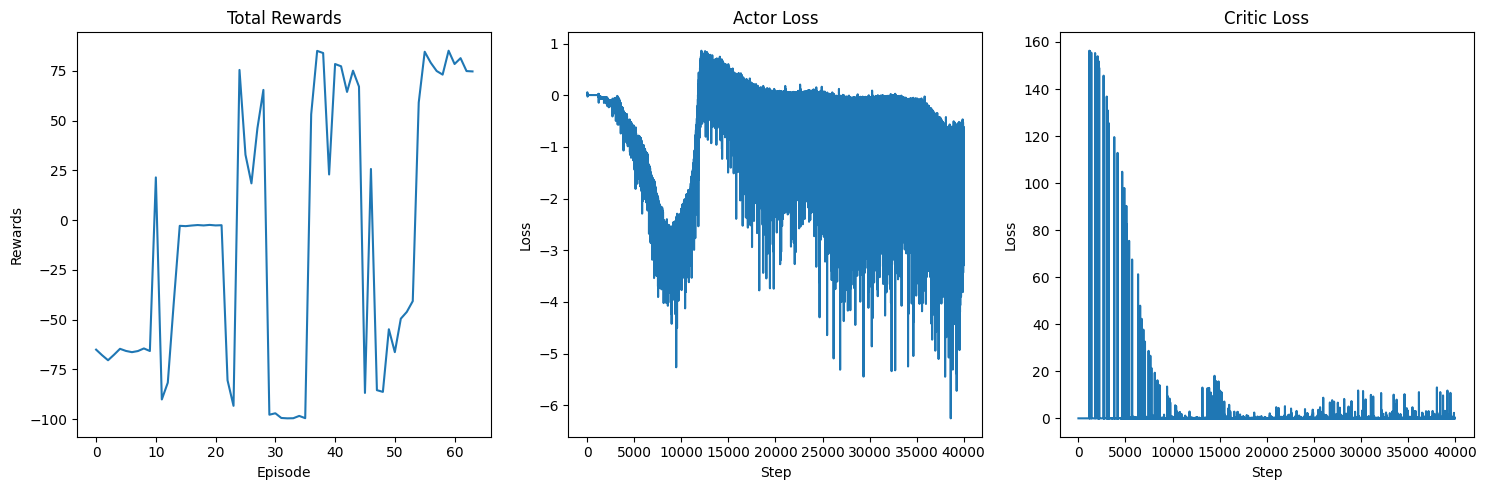

Total Rewards:  94.94234457445828
Total Rewards:  94.79414595006602


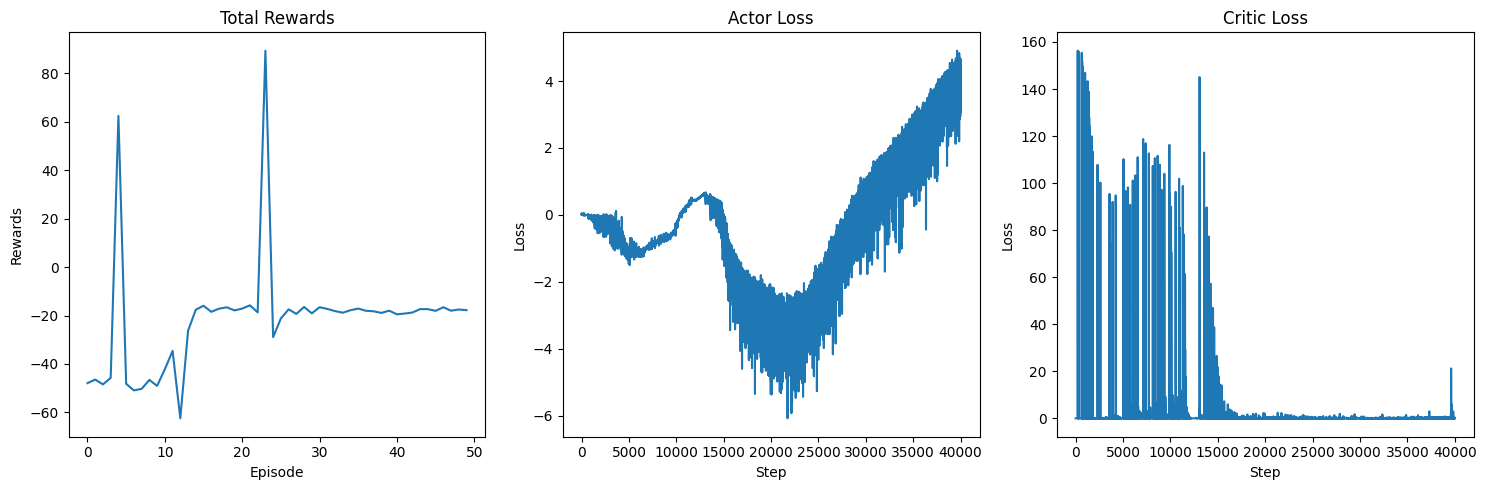

Total Rewards:  -99.8999999999986
Total Rewards:  -99.8999999999986


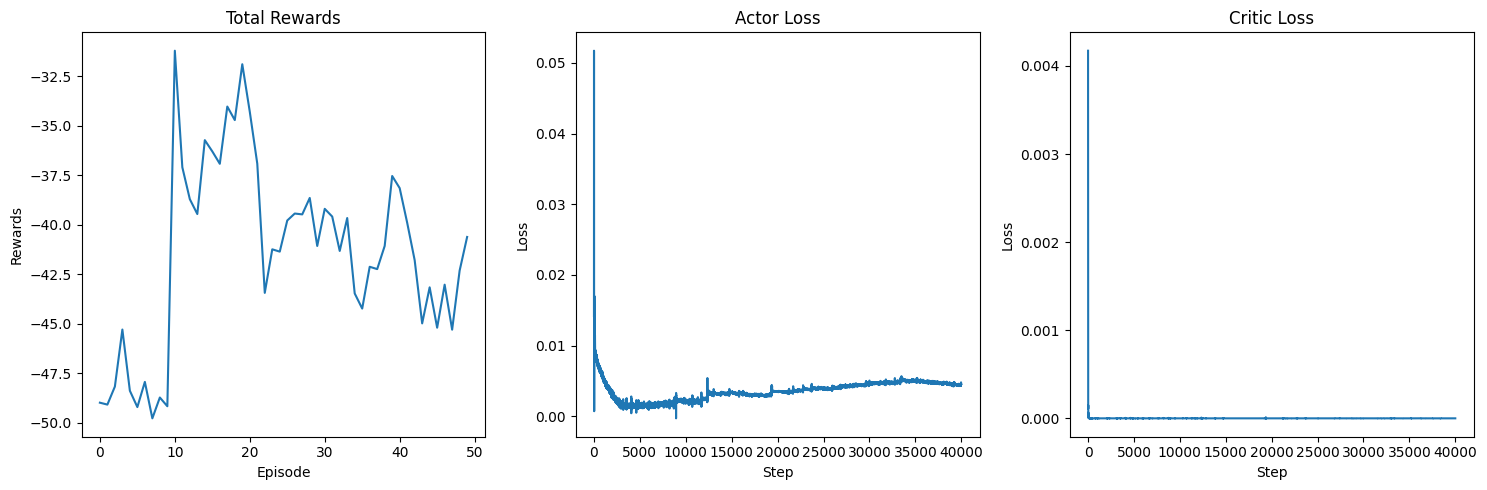

Total Rewards:  -0.2259160111399352
Total Rewards:  -0.22579393290407582


In [ ]:
num_frames=50000
from sklearn.model_selection import ParameterGrid
from IPython.display import display, HTML


# Define hyperparameters and their ranges
hyperparameters = {
    'ou_noise_theta': [ 0.15,  0.25],
    'ou_noise_sigma': [ 0.1, 0.3],
    'gamma': [0.05, 0.95],
    'tau': [ 5e-3, 1e-2],
}

# Create a list of hyperparameter combinations to try
param_grid = ParameterGrid(hyperparameters)

# Initialize variables to store the best hyperparameters and scores
best_hyperparams = None
best_score = -100

gridds=[]
# Iterate over each hyperparameter combination
for params in param_grid:
    # Create agent with current hyperparameters
    text = "Current Parameters: theta = {}, sigma= {}, gamma= {}, tau= {}".format(
        params['ou_noise_theta'],
        params['ou_noise_sigma'],
        params['gamma'],
        params['tau']
    )
    gridds.append([params['ou_noise_theta'],
        params['ou_noise_sigma'],
        params['gamma'],
        params['tau']])
    font_size = 20
    alignment = "center"

    # Use HTML formatting to set the font size and alignment
    html_text = f'<div style="font-size: {font_size}px; text-align: {alignment};"><b>{text}</b></div>'


    # Display the text with increased font size and centered alignment
    display(HTML(html_text))


    agent = DDPGAgent(
        env,
        memory_size,
        batch_size,
        params['ou_noise_theta'],
        params['ou_noise_sigma'],
        gamma=params['gamma'],
        tau=params['tau'],
        initial_random_steps=initial_random_steps
    )
    # Train the agent
    agent.train(num_frames)

    # Test the agent
    score = agent.test()[1]

    if IN_COLAB:
      agent.env = RecordVideo(agent.env, "videos")
    grid_frames = agent.test()[0]
    display_agent_video(grid_frames)

    # Check if the current hyperparameters result in a better score

    # print(score, best_score)
    if score > best_score:
        best_score = score
        best_hyperparams = params




In [ ]:
print("Best hyperparameters:", best_hyperparams)
print("Best score:", best_score)

Best hyperparameters: {'gamma': 0.95, 'ou_noise_sigma': 0.3, 'ou_noise_theta': 0.15, 'tau': 0.01}
Best score: 94.94234457445828


From these results of the hyperparameter tuning, we deduced that certain hyperparameters significantly impact the performance of the DDPG algorithm in this environment. As there isn't a linear correlation between parameters and rewards, hyperparameter tuning through methods like grid search or Bayesian optimization is crucial when implementing DDPG. Additionally, we observed a consistent decrease in actor loss, indicating improvement in action selection for higher rewards. Similarly, the decrease in critic loss suggests enhancement in predicting future rewards for given state-action pairs by the critic network.